In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent, taking advantage of the native tools / middleware, but extending it with custom instructions and tools for the research task. 

## Instructions
 
First, we'll define a prompt that instructs our agent to use available search tools. To prevent excessive tool calls and maintain research focus, we'll use [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

These techniques transform problematic research behavior like:
```
"best coffee shops SF" → "Saint Frank Coffee details" → "Sightglass Coffee details" → "Ritual Coffee details" → etc. (20+ searches)
```

Into efficient patterns like:
```
"best coffee shops SF" → ThinkTool(analyze results) → "SF specialty coffee quality ratings" → ThinkTool(assess completeness) → provide answer (3-5 searches total)
```

The key insight: **Think like a human researcher with limited time** - this prevents the "spin-out problem" where agents continue searching indefinitely.

In [3]:
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

In [5]:
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SUBAGENT_DELEGATION_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + RESEARCHER_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  2. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool                                   │
│  4. **Synthesize**: After collecting research, read `/research_request.md` to confirm you've addressed all      │
│  aspects                                                                                                        │
│  5. **Respond**: Provide a comprehensive answer based on the collected research                                 │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # Sub-Agent Research Coordination                                                                              │
│                                                                                                                 │
│  Your role is to coordinate research by delegating tasks from your TODO list to specialized research            │
│  sub-agents.                                                                                                    │
│                                                                                                                 │
│  ## Delegation Strategy                                                                                         │
│                                                                                                                 │
│  **Simple queries** → 1 sub-agent:                                                                              │
│  - "List the top 10 coffee shops in San Francisco"                                                              │
│  - "What is quantum computing?"                                                                                 │
│  - "Summarize the history of the internet"                                                                      │
│                                                                                                                 │
│  **Comparisons** → 1 sub-agent per element:           

## Tools 

We'll use the native deepagents tools along with a few research-specific tools.

### Search Tool 

We'll build a simple search tool that uses **Tavily purely as a URL discovery engine**, then fetches the full webpage content. This design has several advantages:

- **No information loss**: Returns full webpage content as markdown without summarization
- **Simple and transparent**: Clear two-step process (URL discovery → content fetch)
- **Robust error handling**: Proper User-Agent headers prevent 403 errors, graceful fallbacks for unreachable sites

The tool has three main components:

1. **URL Discovery**: Uses Tavily API to find relevant URLs based on the search query, with configurable parameters for results count and topic filtering.

2. **Content Fetching (`fetch_webpage_content`)**: Fetches full webpage content via HTTP with proper User-Agent headers (to avoid 403 Forbidden errors from sites like Wikipedia), converts HTML to markdown using `markdownify`, and includes error handling for unreachable sites.

3. **Main Tool (`tavily_search`)**: Coordinates the URL discovery and content fetching, returning the full markdown content to the agent for analysis.

### Think Tool 

We provide a think tool - a reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow. [Some research](https://www.anthropic.com/engineering/claude-think-tool) has suggested that think tools can help steer agents towards better solutions, and the think tool is a useful way to help audit agent decision making. Note that some models, such as Claude, now [include interleaved thinking with the SDK](https://docs.claude.com/en/docs/build-with-claude/extended-thinking).

In [7]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Subagent

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

In [8]:
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS,
    "tools": [tavily_search, think_tool],
}

## Putting it all together

Now, we create our deepagent with these components. 

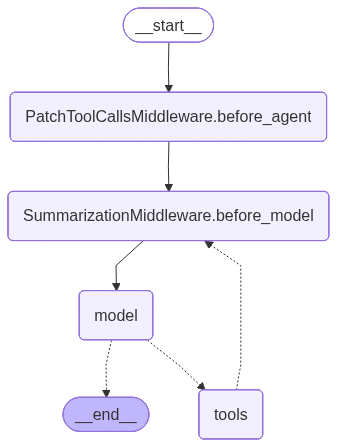

In [9]:
from datetime import datetime
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from deepagents import create_deep_agent

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Create the agent
agent = create_deep_agent(
      model=model,
      tools=[tavily_search, think_tool], 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of context engineering.",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of context engineering.                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll research context engineering for you and provide a comprehensive overview.                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md",                                                                          │
│   "content": "# Research Request\n\n## User Question\nGive me an overview of context engineering.\n\n##         │
│ Date\n2025-01-10\n\n## Research Objectives\n- Define what context engineering is\n- Explain key concepts and    │
│ principles\n- Identify main techniques and approaches\n- Understand applications and use cases\n- Gather        │
│ relevant examples\n"                                                                                            │
│ }                                                                                                               │
│    ID: toolu_01Uni1oVjS5u92ZAXBBSVE2D                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "context engineering definition overview"                                                            │
│ }                                                                                                               │
│    ID: toolu_01GB2kvxviV4vsZbVJaPpzHm                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'context engineering definition overview':                                             │
│                                                                                                                 │
│ ## Context Engineering: A Guide With Examples - DataCamp                                                        │
│ **URL:** https://www.datacamp.com/blog/context-engineering                                                      │
│                                                                                                                 │
│ Context Engineering: A Guide With Examples | DataCamp                                                           │
│                                                                                                                 │
│ [Skip to main content](#main)                                                                                   │
│                                                                                                                 │
│ EN                                                                                                              │
│                                                                                                                 │
│ [English](/blog/context-engineering)[Español](/es/blog/context-engineering)[Português](/pt/blog/context-enginee │
│ ring)[DeutschBeta](/de/blog/context-engineering)[FrançaisBeta](/fr/blog/context-engineering)                    │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ [More                                                                                                           │
│ Information](https://support.datacamp.com/hc/en-us/articles/30943304136727-DataCamp-in-Multiple-Languages)Found │
│ an Error?                                                                                                       │
│                                                                                                                 │
│ blogs                                                                                                           │
│                                                                                                                 │
│ [Blogs](/blog)                                                                                                  │
│                                                                                                                 │
│ [Tutorials](/tutorial)                                                                                          │
│                                                                                                                 │
│ (/doc)                                                                                                          │
│                                                                                                                 │
│ [Podcasts](/podcast)                                                                                            │
│                                                                                                                 │
│ [Cheat Sheets](/cheat-sheet)                                                                                    │
│                                                                                                                 │
│ (/code-along)                                                                                                   │
│                                                         

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "\nGreat! I found a comprehensive DataCamp article on context engineering. Let me analyze what  │
│ I've learned:\n\n**Key findings from this search:**\n1. **Definition**: Context engineering is the practice of  │
│ designing systems that decide what information an AI model sees before it generates a response\n2. **Key        │
│ difference from prompt engineering**: Prompt engineering = writing instructions for single tasks; Context       │
│ engineering = designing systems that manage information flow across multiple interactions\n3. **Main            │
│ components**: System instructions, conversation history, user preferences, retrieved information, available     │
│ tools, structured output formats, real-time data\n4. **Applications**: RAG systems, AI agents, AI coding        │
│ assistants\n5. **Common failures**: Context poisoning, context distraction, context confusion, context          │
│ clash\n6. **Mitigation techniques**: Context validation/quarantine, summarization, tool loadout management,     │
│ context pruning/offloading\n\nThis is excellent information! The article is very comprehensive and covers:\n-   │
│ What context engineering is\n- How it differs from prompt engineering\n- Practical applications (RAG, agents,   │
│ coding assistants)\n- Common problems and solutions\n- Real examples and research citations\n\n**Do I need more │
│ searches?**\nThis single article provides a very thorough overview. However, I should check if there are other  │
│ perspectives or additional technical details that would enhance the overview. Let me do one more search to see  │
│ if there are other authoritative sources or different angles on context engineering.\n"                         │
│ }                                                                                                               │
│    ID: toolu_01ALwnQYhiWVVHwGL4cYVtrp                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded:                                                                                            │
│ Great! I found a comprehensive DataCamp article on context engineering. Let me analyze what I've learned:       │
│                                                                                                                 │
│ **Key findings from this search:**                                                                              │
│ 1. **Definition**: Context engineering is the practice of designing systems that decide what information an AI  │
│ model sees before it generates a response                                                                       │
│ 2. **Key difference from prompt engineering**: Prompt engineering = writing instructions for single tasks;      │
│ Context engineering = designing systems that manage information flow across multiple interactions               │
│ 3. **Main components**: System instructions, conversation history, user preferences, retrieved information,     │
│ available tools, structured output formats, real-time data                                                      │
│ 4. **Applications**: RAG systems, AI agents, AI coding assistants                                               │
│ 5. **Common failures**: Context poisoning, context distraction, context confusion, context clash                │
│ 6. **Mitigation techniques**: Context validation/quarantine, summarization, tool loadout management, context    │
│ pruning/offloading                                                                                              │
│                                                                                                                 │
│ This is excellent information! The article is very comprehensive and covers:                                    │
│ - What context engineering is                                                                                   │
│ - How it differs from prompt engineering                                                                        │
│ - Practical applications (RAG, agents, coding assistants)                                                       │
│ - Common problems and solutions                                                                                 │
│ - Real examples and research citations                                                                          │
│                                                                                                                 │
│ **Do I need more searches?**                                                                                    │
│ This single article provides a very thorough overview. However, I should check if there are other perspectives  │
│ or additional technical details that would enhance the overview. Let me do one more search to see if there are  │
│ other authoritative sources or different angles on context engineering.                                         │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "context engineering AI techniques best practices 2025"                                              │
│ }                                                                                                               │
│    ID: toolu_01EQDRPfP8N6888myzLehSsU                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Found 1 result(s) for 'context engineering AI techniques best practices 2025':                               │
│                                                                                                                 │
│ ## Context Engineering: The AI Skill You Should Master in 2025                                                  │
│ **URL:** https://www.charterglobal.com/context-engineering-ai-skill-2025/                                       │
│                                                                                                                 │
│    Context Engineering: The AI Skill You Should Master in 2025 | Charter Global                                 │
│                                                                                                                 │
│ [![Charter Global](https://www.charterglobal.com/wp-content/uploads/2025/11/logo-white-1.png "Charter           │
│ Global")](https://www.charterglobal.com)                                                                        │
│                                                                                                                 │
│ * Practices                                                                                                     │
│   + - * [Digital Transformation](https://www.charterglobal.com/services/digital-strategy-and-transformation/)   │
│         + [Cloud Modernization](https://www.charterglobal.com/services/cloud-modernization/)                    │
│         + [SaaS Development](https://www.charterglobal.com/services/saas-development/)                          │
│         + [Custom Software Development](https://www.charterglobal.com/services/custom-software-development/)    │
│     - * [Data Modernization](https://www.charterglobal.com/services/data-modernization/)                        │
│         + [Migration & Integration](https://www.charterglobal.com/services/migration-and-integration/)          │
│         + [Artificial Intelligence (AI)](https://www.charterglobal.com/services/artificial-intelligence/)       │
│         + [Business Intelligence and Analytics](https://www.charterglobal.com/services/business-intelligence/)  │
│     - * [Agentic Process Automation](https://www.charterglobal.com/services/agentic-process-automation/)        │
│         + [AI Automation Platform](https://www.charterglobal.com/services/ai-automation-platform/)              │
│         + [Automation (RPA+BPA)](https://www.charterglobal.com/services/intelligent-automation/)                │
│ * (https://www.charterglobal.com/services/ideation-to-launch/)                                                  │
│   + - * [Ideation to Launch](https://www.charterglobal.com/services/ideation-to-launch/)                        │
│         + [Software Development for                                                                             │
│ Startups](https://www.charterglobal.com/services/software-development-for-startups/)                            │
│         + [Full Stack Development](https://www.charterglobal.com/services/full-stack-development/)              │
│         + [Strategic Advisory](https://www.charterglobal.com/services/strategic-advisory/)                      │
│ * [About Us](/about-charter-global/)                                                                            │
│   + - * #### About Us                                                                                           │
│   + - * [Why Charter Global?](https://www.charterglobal.com/why-choose-us/)                                     │
│       * [Culture](https://www.charterglobal.com/culture/)                                                       │
│       * [Approach](https://www.charterglobal.com/our-approach/)                                                 │
│       * [Success Stories](https://www.charterglobal.com/

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "\nExcellent! I found another comprehensive article from Charter Global that provides           │
│ additional perspectives and details on context engineering. Let me analyze what new information this            │
│ adds:\n\n**New insights from this second source:**\n\n1. **More detailed definition**: Context engineering is   │
│ described as \"the strategic design and structuring of the environment, input data, and interaction flows that  │
│ influence how an AI system interprets and responds to information\"\n\n2. **Additional key components not       │
│ covered in first article**:\n   - Input normalization\n   - Metadata enrichment\n   - Interaction design\n   -  │
│ Response validation and post-processing\n\n3. **Best practices for scalability**:\n   - Token budgeting         │
│ strategies\n   - Role-based prompt templates\n   - Session state design patterns\n   - Real-time context        │
│ enrichment via APIs\n\n4. **More specific challenges**:\n   - Context window limitations\n   - Data privacy and │
│ security\n   - Tooling and infrastructure gaps\n   - Lack of standardization\n   - Evolving model               │
│ behavior\n\n5. **Tools and frameworks mentioned**:\n   - LangChain and LlamaIndex\n   - Microsoft Semantic      │
│ Kernel\n   - OpenAI Assistants API\n   - RAG frameworks\n\n**What I now have:**\n- Clear definition from        │
│ multiple sources\n- Comprehensive understanding of components\n- Practical applications (RAG, agents, coding    │
│ assistants)\n- Common problems and solutions\n- Best practices for implementation\n- Tools and frameworks\n-    │
│ Comparison with prompt engineering\n- Real-world challenges\n\n**Do I need more searches?**\nI now have two     │
│ comprehensive sources that cover context engineering from different angles. The DataCamp article provides       │
│ excellent technical depth on failures and mitigation techniques, while the Charter Global article provides more │
│ enterprise/practical implementation perspective. Together, these give a well-rounded overview.\n\nI have enough │
│ information to provide a comprehensive overview. I should stop here and synthesize the findings into a clear,   │
│ structured response for the user.\n"                                                                            │
│ }                                                                                                               │
│    ID: toolu_01SPhRWtvuCrMRCDTkDsbyEs                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded:                                                                                            │
│ Excellent! I found another comprehensive article from Charter Global that provides additional perspectives and  │
│ details on context engineering. Let me analyze what new information this adds:                                  │
│                                                                                                                 │
│ **New insights from this second source:**                                                                       │
│                                                                                                                 │
│ 1. **More detailed definition**: Context engineering is described as "the strategic design and structuring of   │
│ the environment, input data, and interaction flows that influence how an AI system interprets and responds to   │
│ information"                                                                                                    │
│                                                                                                                 │
│ 2. **Additional key components not covered in first article**:                                                  │
│    - Input normalization                                                                                        │
│    - Metadata enrichment                                                                                        │
│    - Interaction design                                                                                         │
│    - Response validation and post-processing                                                                    │
│                                                                                                                 │
│ 3. **Best practices for scalability**:                                                                          │
│    - Token budgeting strategies                                                                                 │
│    - Role-based prompt templates                                                                                │
│    - Session state design patterns                                                                              │
│    - Real-time context enrichment via APIs                                                                      │
│                                                                                                                 │
│ 4. **More specific challenges**:                                                                                │
│    - Context window limitations                                                                                 │
│    - Data privacy and security                                                                                  │
│    - Tooling and infrastructure gaps                                                                            │
│    - Lack of standardization                                                                                    │
│    - Evolving model behavior                                                                                    │
│                                                                                                                 │
│ 5. **Tools and frameworks mentioned**:                                                                          │
│    - LangChain and LlamaIndex                                                                                   │
│    - Microsoft Semantic Kernel                                                                                  │
│    - OpenAI Assistants API                                                                                      │
│    - RAG frameworks                                    

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: toolu_01WXcaud72PDPmqNUip5VuZD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Research Request                                                                                      │
│      2                                                                                                          │
│      3  ## User Question                                                                                        │
│      4  Give me an overview of context engineering.                                                             │
│      5                                                                                                          │
│      6  ## Date                                                                                                 │
│      7  2025-01-10                                                                                              │
│      8                                                                                                          │
│      9  ## Research Objectives                                                                                  │
│     10  - Define what context engineering is                                                                    │
│     11  - Explain key concepts and principles                                                                   │
│     12  - Identify main techniques and approaches                                                               │
│     13  - Understand applications and use cases                                                                 │
│     14  - Gather relevant examples                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I've gathered comprehensive information about context engineering from two authoritative sources. Let  │
│ me now provide you with a detailed overview.                                                                    │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Overview of Context Engineering                                                                              │
│                                                                                                                 │
│ ### What is Context Engineering?                                                                                │
│                                                                                                                 │
│ **Context engineering** is the practice of designing systems that strategically manage what information an AI   │
│ model sees before it generates a response. Rather than just crafting individual prompts, context engineering    │
│ involves building systems that gather, organize, and present relevant information from multiple sources within  │
│ the model's context window.                                                                                     │
│                                                                                                                 │
│ As Andrej Karpathy explains, while people often associate prompts with short task descriptions, "in every       │
│ industrial-strength LLM app, context engineering is the delicate art and science of filling the context window  │
│ with just the right information for the next step."                                                             │
│                                                                                                                 │
│ ### Context Engineering vs. Prompt Engineering                                                                  │
│                                                                                                                 │
│ The key distinction:                                                                                            │
│                                                                                                                 │
│ - **Prompt Engineering**: Writing instructions for single, one-off tasks (e.g., "write a professional email")   │
│ - **Context Engineering**: Designing systems that manage information flow across multiple interactions and      │
│ maintain state over time                                                                                        │
│                                                                                                                 │
│ Context engineering is more holistic, encompassing user-specific context, task context, temporal/environmental  │
│ factors, and real-time data integration—treating the AI model as a component within a dynamic system rather     │
│ than a static entity.                                                                                           │
│                                                                                                                 │
│ ### Key Components                                                                                              │
│                                                                                                                 │
│ Context engineering manages several types of information:                                                       │
│                                                        

Trace: 

https://smith.langchain.com/public/5bcbf8ea-f5ac-458d-b28b-fdeca132e7b5/r